In [1]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

## Inpainting Functions

In [2]:
def identify_missing_regions(damaged_image):
    _, binary_image = cv2.threshold(damaged_image, 10, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=1)
    binary_image = cv2.dilate(binary_image, kernel, iterations=2)
    
    labeled_image = measure.label(binary_image, connectivity=2)
    regions = measure.regionprops(labeled_image)
    
    return labeled_image, regions, binary_image

def sort_regions_by_area(regions):
    sorted_regions = sorted(regions, key=lambda region: region.area, reverse=True)
    return sorted_regions

def check_if_empty(L):
    if not L:
        print("List L is empty. The inpainting process is complete.")
        return True
    else:
        print("List L is not empty. Proceeding to the next steps.")
        return False
def select_and_dilate_smallest_region(L, original_image, dilation_size=10, dilation_iterations=2):
    if not L:
        raise ValueError("List L is empty. Cannot select and dilate the smallest region.")

    smallest_region = L[-1]
    

    mask = np.zeros(original_image.shape, dtype=np.uint8)
    for coord in smallest_region.coords:
        mask[coord[0], coord[1]] = 255
    
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return mask, dilated_mask
def crop_corresponding_area(dilated_mask, original_image):
    coords = cv2.findNonZero(dilated_mask)
    x, y, w, h = cv2.boundingRect(coords)
    
    cropped_area = original_image[y:y+h, x:x+w]
    
    return cropped_area, (x, y, w, h)
def compute_smoothing_parameter(cropped_image):

    I_x = cv2.Sobel(cropped_image, cv2.CV_64F, 1, 0, ksize=1)
    I_y = cv2.Sobel(cropped_image, cv2.CV_64F, 0, 1, ksize=1)
    
    G = np.sqrt(I_x**2 + I_y**2)

    rho = np.max(G)
    sigma = np.exp(1 - (rho / 255))
    
    return sigma, I_x, I_y

def dilated_mask_crop(cropped_image):

    _, dilated_mask = cv2.threshold(cropped_image, 10, 255, cv2.THRESH_BINARY_INV)

    return dilated_mask
def create_training_data_from_cropped(cropped_image, dilated_mask, neighbor_radius=10):
    assert cropped_image.shape == dilated_mask.shape, "Dimensions of cropped image and mask must match."

    inpainting_region = dilated_mask.astype(bool)

    if cropped_image.ndim == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    neighbor_mask = cv2.dilate(inpainting_region.astype(np.uint8), 
                               np.ones((2 * neighbor_radius + 1, 2 * neighbor_radius + 1), np.uint8), 
                               iterations=1) & ~inpainting_region

    coords = np.column_stack(np.where(neighbor_mask))

    pixel_values = cropped_image[coords[:, 0], coords[:, 1]]

    return coords, pixel_values.reshape(-1, 1)
from scipy.spatial.distance import cdist
class OptimizedGRNN:
    def __init__(self, sigma=None):
        self.sigma = sigma
        self.training_set = None
        self.target_values = None

    def fit(self, features, targets):
        self.training_set = features
        self.target_values = targets

    def predict(self, features, batch_size=1000):
        predictions = []
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_features = features[start:end]
            
            distance_matrix = cdist(batch_features, self.training_set, 'sqeuclidean')
            kernel_matrix = np.exp(-distance_matrix / (2 * self.sigma ** 2))
            batch_predictions = np.dot(kernel_matrix, self.target_values) / kernel_matrix.sum(axis=1)
            
            predictions.append(batch_predictions)
        
        return np.concatenate(predictions, axis=0)
def sharpen_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    
    sharpened_image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    
    return sharpened_image
def anisotropic_diffusion(img, niter=10, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    if img.ndim == 3:
        raise NotImplementedError("3D images are not supported yet.")

    img = img.astype('float32')

    if voxelspacing is not None:
        voxelspacing = np.asanyarray(voxelspacing, dtype='float32')
        gamma = gamma / (np.prod(voxelspacing) ** (1./3.))

    deltaS = np.zeros_like(img)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(img)
    gE = gS.copy()

    for i in range(niter):

        deltaS[:-1, :] = np.diff(img, axis=0)
        deltaE[:, :-1] = np.diff(img, axis=1)

        if option == 1:
            gS = np.exp(-(deltaS/kappa)**2.)
            gE = np.exp(-(deltaE/kappa)**2.)
        elif option == 2:
            gS = 1./(1.+(deltaS/kappa)**2.)
            gE = 1./(1.+(deltaE/kappa)**2.)

        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        img += gamma*(NS+EW)

    return img.astype(np.uint8)
def percentile_area(L):
    area = 0
    for i, region in enumerate(L):
        area += region.area
    main_img = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testdata\main_large.jpg", cv2.IMREAD_GRAYSCALE)
    total_area = main_img.shape[0]*main_img.shape[1]
    return (area/total_area)*100
def identify_noise_regions(noisy_image,original_image_path):
    # Load the original and noisy images
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calculate the noise component
    noise_component = cv2.subtract(noisy_image, original_image)
    noise_level = np.mean(np.abs(noise_component))

    # Threshold the noise component to identify significant deviations (noise)
    _, binary_image = cv2.threshold(noise_component, 30, 255, cv2.THRESH_BINARY)
    
    # Label the binary image
    labeled_image = measure.label(binary_image, connectivity=2)
    regions = measure.regionprops(labeled_image)
    
    return labeled_image, regions, binary_image

In [3]:
def inpaint(path,save_path,original_image_path,noise=False):
    damaged_image_multiple_rectangles = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if not noise:
        _,r, binary_image = identify_missing_regions(damaged_image_multiple_rectangles)
    else:
        _,r, binary_image = identify_noise_regions(damaged_image_multiple_rectangles,original_image_path)
    plt.imshow(binary_image, cmap='gray')
    plt.show()
    # Sort regions by area in descending order and store them in a list tagged as L
    L = sort_regions_by_area(r)
    print(percentile_area(L))
    if not check_if_empty(L):
        # Select and dilate the smallest region
        while L:
            print(len(L))
            mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
            # Turn white noise areas into black
            damaged_image_multiple_rectangles[mask == 255] = 0
            # Crop the corresponding area from the original image
            cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
            
            #cropped_area = anisotropic_diffusion(cropped_area)
            # Compute the smoothing parameter
            sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
            dilated_mask = dilated_mask_crop(cropped_area)
            # Create training data from the cropped area
            print(cropped_area.shape)
            print(dilated_mask.shape)
            X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
            # Fit the GRNN model
            
            print(X_train.shape)

            grnn_model = OptimizedGRNN(sigma=sigma)
            grnn_model.fit(X_train, y_train.ravel())
            # Inpaint the damaged region
            
            inpainted_area = cropped_area.copy()
            damaged_coords = np.column_stack(np.where(dilated_mask))
            if damaged_coords.size > 0:
                predicted_values = grnn_model.predict(damaged_coords)
                inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8)
            else:
                print("No damaged regions found")
                L.pop()
                continue
            
            # Restore the inpainted area back to the original image
            x, y, w, h = bbox
            restored_image = damaged_image_multiple_rectangles.copy()
            restored_image[y:y+h, x:x+w] = inpainted_area
            
            # Save the restored image
            cv2.imwrite(save_path, restored_image)

            # Sharpen the restored image
            sharpened_image = sharpen_image(restored_image)

            # Display the original, inpainted, and sharpened images
            # plt.figure(figsize=(18, 6))

            # plt.subplot(1, 3, 1)
            # plt.title('Before')
            # plt.imshow(damaged_image_multiple_rectangles, cmap='gray')
            # plt.axis('off')

            # plt.subplot(1, 3, 2)
            # plt.title('After')
            # plt.imshow(restored_image, cmap='gray')
            # plt.axis('off')
            damaged_image_multiple_rectangles = restored_image
            plt.show()
            if L:
                L.pop()
        print('done')
    else:
        print("No missing regions found in the image.")

In [4]:
def plot_result(error_path,restored_path):
    restored_image = cv2.imread(restored_path, cv2.IMREAD_GRAYSCALE)
    restored_image = anisotropic_diffusion(restored_image)
    restored_image = sharpen_image(restored_image)
    plt.figure(figsize=(20, 30))
    plt.subplot(1, 3, 1)
    plt.title('Before')
    plt.imshow(cv2.imread(error_path), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('After')
    plt.imshow(restored_image, cmap='gray')
    plt.axis('off')
    plt.show()

## Example usecase : Fill Noise errors

You can turn noise = False in the inpaint function to fill any kind of damages beside noise

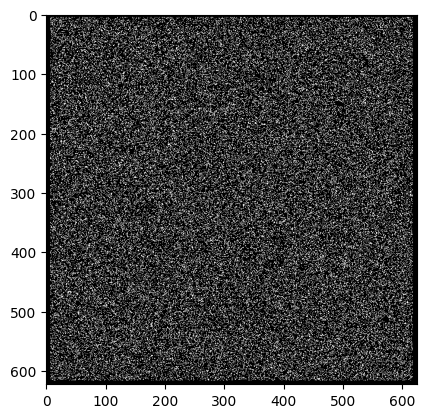

20.014895666131622
List L is not empty. Proceeding to the next steps.
26431
(15, 19)
(15, 19)
(216, 2)
26430
(15, 19)
(15, 19)
(243, 2)
26429
(15, 19)
(15, 19)
(250, 2)
26428
(15, 19)
(15, 19)
(203, 2)
26427
(15, 19)
(15, 19)
(249, 2)
26426
(15, 19)
(15, 19)
(276, 2)
26425
(15, 19)
(15, 19)
(281, 2)
26424
(15, 19)
(15, 19)
(207, 2)
26423
(15, 19)
(15, 19)
(208, 2)
26422
(15, 19)
(15, 19)
(241, 2)
26421
(15, 19)
(15, 19)
(212, 2)
26420
(15, 19)
(15, 19)
(275, 2)
26419
(15, 19)
(15, 19)
(247, 2)
26418
(15, 19)
(15, 19)
(204, 2)
26417
(15, 19)
(15, 19)
(238, 2)
26416
(15, 19)
(15, 19)
(277, 2)
26415
(15, 19)
(15, 19)
(266, 2)
26414
(15, 19)
(15, 19)
(206, 2)
26413
(15, 19)
(15, 19)
(214, 2)
26412
(15, 19)
(15, 19)
(278, 2)
26411
(15, 19)
(15, 19)
(242, 2)
26410
(15, 19)
(15, 19)
(200, 2)
26409
(15, 19)
(15, 19)
(215, 2)
26408
(15, 19)
(15, 19)
(214, 2)
26407
(15, 19)
(15, 19)
(212, 2)
26406
(15, 19)
(15, 19)
(228, 2)
26405
(15, 19)
(15, 19)
(237, 2)
26404
(15, 19)
(15, 19)
(259, 2)
26403


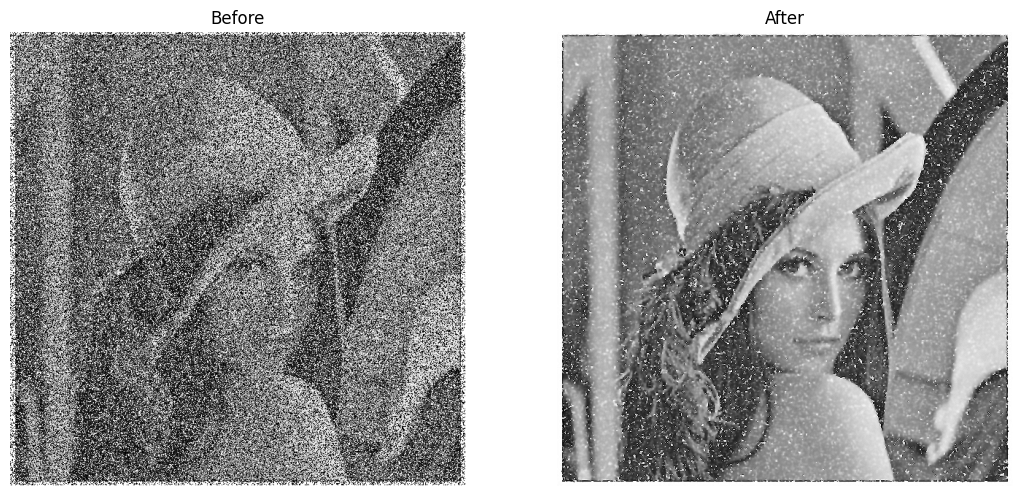

In [14]:
error_path = r"C:\Users\VIET HOANG - VTS\Desktop\Noisy inpaint\Lena\main_large_noisy_70%.jpg"
restored_path = "Abc.jpg"
original_image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testdata\main_large.jpg"
inpaint(error_path,restored_path,original_image_path,noise=True)
plot_result(error_path,restored_path)